<a href="https://colab.research.google.com/github/1262PCS/B7_FINAL-YEAR-PROJECT/blob/main/models/Community_Detection_with_output_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00


In [ ]:
!pip install networkx matplotlib

In [ ]:
!pip install networkx torch scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

# IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


# LOADING CORA WITH PAPER TITLES

In [ ]:
!wget https://people.cs.umass.edu/~mccallum/data/cora.tar.gz

--2024-04-22 22:29:10--  https://people.cs.umass.edu/~mccallum/data/cora.tar.gz
Resolving people.cs.umass.edu (people.cs.umass.edu)... 128.119.240.99
Connecting to people.cs.umass.edu (people.cs.umass.edu)|128.119.240.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264768650 (253M) [application/x-gzip]
Saving to: ‘cora.tar.gz’

cora.tar.gz         100%[===================>] 252.50M  2.73MB/s    in 74s     

2024-04-22 22:30:25 (3.42 MB/s) - ‘cora.tar.gz’ saved [264768650/264768650]



# Extracting contents of dataset

In [ ]:
!tar -zxvf cora.tar.gz


Streaming output truncated to the last 5000 lines.
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#TechRep#ornl.ps
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#Multip#TheParform.ps.Z
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#Multip#mpossurvey.ps.Z
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#Nbody#dfma.ps
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#Nbody#sc92.ps
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#Network#dqdbsim_0.2b#doc#ds_user.ps
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#PADS#summary.ps
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#Papers#nanjing.ps
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#Papers#query.ps
cora/extractions/http:##www.cs.panam.edu#~meng#unix-home#Research#Parsed#IC3Npaper#meng.ps
cora/extractions/http:##www.cs.rpi.edu#~bagalp#prallel.ps
cora/extractions/http:##www.cs.panam.ed

# Load cora.content File into a DataFrame

In [ ]:
df = pd.read_csv('/content/cora/papers', sep='\t', header=None, names=['paper_id', 'word_attributes', 'class_label'])


#  Load Cora Dataset using PyTorch Geometric

In [ ]:
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
aligned_titles = df["class_label"].tolist()
aligned_indices = df["paper_id"].tolist()



Processing...
Done!


# Define a Simple Graph Convolutional Network (GCN) Model

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)  # Changed to hidden_channels

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the Model, Loss Function, and Optimizer

In [ ]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# Training and Testing Functions


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = accuracy_score(data.y[data.test_mask].numpy(), pred[data.test_mask].numpy())
    return acc


# Training Loop

In [ ]:
num_epochs = 500
for epoch in range(1, num_epochs + 1):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')


Epoch: 1, Loss: 1.9563, Test Accuracy: 0.3190
Epoch: 2, Loss: 1.8515, Test Accuracy: 0.3790
Epoch: 3, Loss: 1.7290, Test Accuracy: 0.4000
Epoch: 4, Loss: 1.5942, Test Accuracy: 0.4230
Epoch: 5, Loss: 1.4604, Test Accuracy: 0.4630
Epoch: 6, Loss: 1.3259, Test Accuracy: 0.5350
Epoch: 7, Loss: 1.1913, Test Accuracy: 0.5850
Epoch: 8, Loss: 1.0610, Test Accuracy: 0.6370
Epoch: 9, Loss: 0.9386, Test Accuracy: 0.6720
Epoch: 10, Loss: 0.8248, Test Accuracy: 0.7030
Epoch: 11, Loss: 0.7199, Test Accuracy: 0.7210
Epoch: 12, Loss: 0.6244, Test Accuracy: 0.7360
Epoch: 13, Loss: 0.5383, Test Accuracy: 0.7500
Epoch: 14, Loss: 0.4615, Test Accuracy: 0.7620
Epoch: 15, Loss: 0.3940, Test Accuracy: 0.7800
Epoch: 16, Loss: 0.3353, Test Accuracy: 0.7900
Epoch: 17, Loss: 0.2850, Test Accuracy: 0.7940
Epoch: 18, Loss: 0.2422, Test Accuracy: 0.7950
Epoch: 19, Loss: 0.2061, Test Accuracy: 0.8000
Epoch: 20, Loss: 0.1756, Test Accuracy: 0.8040
Epoch: 21, Loss: 0.1500, Test Accuracy: 0.8090
Epoch: 22, Loss: 0.128

In [ ]:

# Final Evaluation
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
acc = accuracy_score(data.y[data.test_mask].numpy(), pred[data.test_mask].numpy())
num_features = out.shape[1]  # Number of output features

# Print final evaluation details
print(f'Final Evaluation - Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Num Features: {num_features}')


Final Evaluation - Loss: 0.0072, Test Accuracy: 0.8110, Num Features: 7


#  Visualize the Graph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

G = nx.Graph()
edge_index = data.edge_index.cpu().numpy()
for i in range(edge_index.shape[1]):
    src, tgt = edge_index[0, i], edge_index[1, i]
    G.add_edge(src, tgt)



In [ ]:
!pip uninstall -y python-louvain
!pip install python-louvain

Found existing installation: python-louvain 0.16
Uninstalling python-louvain-0.16:
  Successfully uninstalled python-louvain-0.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9389 sha256=b9522177e43ef0c18156951a56db39af9d8ad6d88e86b465f0c155fd96229d9e
  Stored in directory: /root/.cache/pip/wheels/d0/b0/d7/6dd26c3817810fa379088eaeb755a01d9a2a411c37632079d1
Successfully built python-louvain


In [ ]:
from community import community_louvain

In [ ]:
# Louvain community detection
partition = community_louvain.best_partition(G)
# Extract community labels
community_labels = list(partition.values())

isolated_nodes = []
small_components = []

for node, community_id in partition.items():
    if len([n for n, cid in partition.items() if cid == community_id]) == 1:
        isolated_nodes.append(node)
    elif len([n for n, cid in partition.items() if cid == community_id]) <= 5:
        small_components.append(node)

print("Isolated Nodes:", isolated_nodes)
print("Small Connected Components:", small_components)

for nodes, community_id in partition.items():
  G.nodes[node]['community'] = community_id
  print(f"Community of {nodes}: {community_id}")

Isolated Nodes: []
Small Connected Components: [2544, 3, 208, 7, 1001, 12, 1318, 2661, 2662, 1594, 31, 1582, 44, 2624, 2701, 2631, 66, 2461, 106, 259, 117, 2537, 520, 184, 1208, 187, 1439, 200, 2676, 821, 222, 2255, 225, 2583, 247, 2429, 250, 2705, 287, 2562, 292, 991, 307, 385, 369, 2484, 477, 380, 930, 2569, 2483, 1108, 390, 1170, 404, 1476, 545, 422, 2694, 431, 2695, 1048, 462, 1181, 474, 1286, 538, 774, 560, 2526, 585, 1032, 587, 2669, 592, 2690, 611, 1024, 625, 2058, 635, 2704, 641, 1231, 653, 932, 662, 954, 677, 2629, 692, 1691, 700, 1044, 713, 1034, 721, 2341, 780, 947, 786, 2600, 832, 2639, 917, 2173, 939, 2565, 953, 2566, 2567, 1112, 2529, 959, 2659, 967, 1496, 974, 2697, 986, 1541, 1005, 1036, 1600, 1059, 1648, 1210, 2433, 1233, 2479, 1236, 1407, 1263, 2703, 1298, 2692, 1310, 1613, 1356, 1393, 1371, 2586, 1375, 1544, 1378, 2150, 2664, 1438, 1657, 1554, 2686, 2687, 2688, 2633, 1563, 2660, 1673, 2174, 2411, 2410, 2432, 2431, 2603, 2602, 2619, 2618, 2626, 2625, 2635, 2634, 2636,

In [ ]:
def get_community_label(node_id):
  for nodes, community_id in partition.items():
    if(nodes==node_id):
      return community_id
    else:
      continue

def get_community_info(node_id):
    community_label=get_community_label(node_id)
    # Get the nodes in the same community as the input node
    community_nodes = [node for node, cid in partition.items() if cid == community_label]

    # Compute degree centrality for the input node within its community
    community_subgraph = G.subgraph(community_nodes)
    node_degree_centrality = nx.degree_centrality(community_subgraph)
    influence = node_degree_centrality[node_id]

    print(f"Node {node_id} has degree centrality of {influence:.3f} in Community {community_label}.")
    return community_nodes

<ipython-input-19-d3e6d452745b>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(G, pos, node_size=10, node_color=community_labels, cmap=plt.cm.get_cmap('viridis', max(community_labels) + 1))


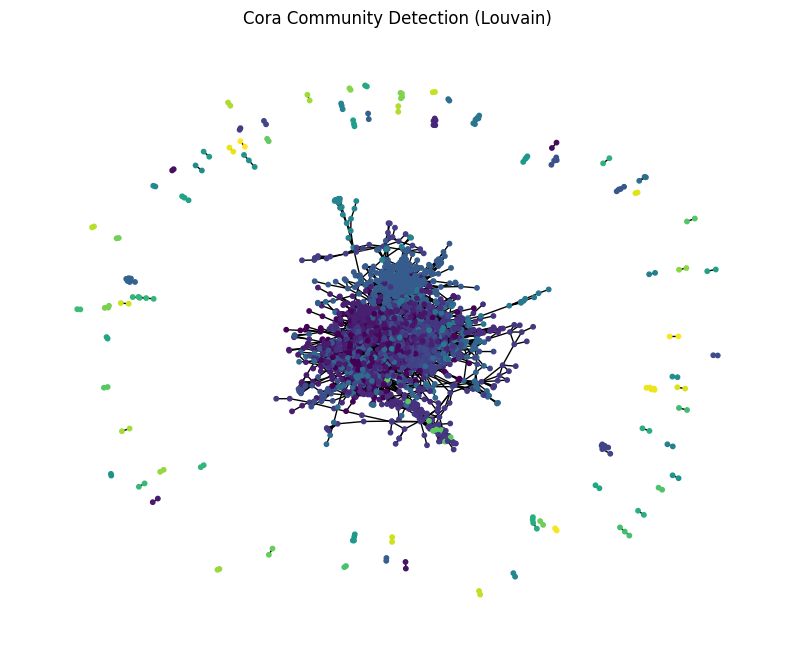

In [ ]:
# Visualize all nodes and their communities
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10,8))
plt.title("Cora Community Detection (Louvain)")
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=community_labels, cmap=plt.cm.get_cmap('viridis', max(community_labels) + 1))
nx.draw_networkx_edges(G, pos, alpha=1)
plt.axis('off')

plt.show()

In [ ]:
print("Number of nodes:", len(G.nodes))
print("Number of communities:", len(set(community_labels)))

Number of nodes: 2708
Number of communities: 105


# Display Paper Titles Under Various Categories After Classification

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
predicted_labels = out.argmax(dim=1)
category_titles = {category: [] for category in range(dataset.num_classes)}

for idx, label in enumerate(predicted_labels):
    # Find the original index in the dataframe based on PyG's node indices
    mask_indices = (data.test_mask.nonzero().view(-1) == idx).nonzero()

    # Check if the index is found and within the bounds of the aligned_titles list
    if mask_indices.numel() > 0:
        original_idx = mask_indices.item()
        if original_idx < len(aligned_titles):
            category_titles[label.item()].append(aligned_titles[original_idx])



In [ ]:
!pip install ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML  # Import HTML for creating clickable links

class_labels_to_names = {
    0: 'Theory',
    1: 'Reinforcement_Learning',
    2: 'Genetic_Algorithms',
    3: 'Neural_Networks',
    4: 'Probabilistic_Methods',
    5: 'Case_Based',
    6: 'Rule_Learning'
}

# Assuming you have defined 'model', 'data', 'aligned_titles', and 'class_labels_to_names' before this point

# Set the model to evaluation mode
model.eval()

# Forward pass to get predictions
out = model(data.x, data.edge_index)

# Get predicted labels
predicted_labels = out.argmax(dim=1)

# Replace class labels with category names
predicted_category_names = [class_labels_to_names[label.item()] for label in predicted_labels]

# Create a dictionary to store lists of titles for each category
category_titles = {category_name: [] for category_name in class_labels_to_names.values()}
category_titles['Miscellaneous'] = []

# Loop through predicted category names and aligned titles
for idx, category_name in enumerate(predicted_category_names):
    # Find the original index in the dataframe based on PyG's node indices
    mask_indices = (data.test_mask.nonzero().view(-1) == idx).nonzero()

    # Check if the index is found and within the bounds of the aligned_titles list
    if mask_indices.numel() > 0:
        original_idx = mask_indices.item()
        if original_idx < len(aligned_titles):
            # Remove text enclosed in square brackets from the title
            cleaned_title = re.sub(r'\[.*?\]', '', aligned_titles[original_idx]).strip()

            # Append the cleaned title to the corresponding category's list
            category_titles[category_name].append(cleaned_title)

print(category_titles)



{'Theory': ['<author> Liskov B., Day M., Shrira L. </author> <title> Distributed Object Management in Thor. </title> <editor> In M. Tamer Ozsu and Umesh Dayal and Patrick Valduriez, editors, </editor> <booktitle> Distributed Object Management. </booktitle> <address> San Mateo, California, </address> <year> 1993. </year>', "<author> Dawson R. Engler, M. Frans Kaashoek, and James W. O\\'Toole Jr. Exokernel: </author> <title> An operating system architecture for application-level resource management. </title> <booktitle> In Proceedings of the Fifteenth ACM Symposium on Operating Systems Principles , December 1995. </booktitle>", "<author> Christos Faloutsos, M. Ranganathan, and Yannis Manolopoulos. </author> <title> Fast subsequence matching in time-series databases. </title> <booktitle> Proc. ACM SIGMOD, </booktitle> <pages> pages 419-429, </pages> <month> May </month> <year> 1994. </year> <note> `Best Paper\\' award; also available as CS-TR-3190, UMIACS-TR-93-131. 24 </note>", "<author>

In [ ]:
# Dictionary to store modified titles
modified_category = {}

# Loop through each category and its titles
for category, titles in category_titles.items():
    modified_category[category] = []  # Initialize an empty list for each category
    for title in titles:
        # Extract text within '<>' using regular expression
        key_value_pairs = re.findall(r'<(.*?)>(.*?)</\1>', title)
        row_data = {}  # Initialize a dictionary to store row data
        for key, value in key_value_pairs:
            # Add key-value pairs to the row_data dictionary
            row_data[key] = value
        # Append the row_data to the modified_category list for the current category
        modified_category[category].append(row_data)

# Print the modified titles dictionary
print(modified_category)


{'Theory': [{'author': ' Liskov B., Day M., Shrira L. ', 'title': ' Distributed Object Management in Thor. ', 'editor': ' In M. Tamer Ozsu and Umesh Dayal and Patrick Valduriez, editors, ', 'booktitle': ' Distributed Object Management. ', 'address': ' San Mateo, California, ', 'year': ' 1993. '}, {'author': " Dawson R. Engler, M. Frans Kaashoek, and James W. O\\'Toole Jr. Exokernel: ", 'title': ' An operating system architecture for application-level resource management. ', 'booktitle': ' In Proceedings of the Fifteenth ACM Symposium on Operating Systems Principles , December 1995. '}, {'author': ' Christos Faloutsos, M. Ranganathan, and Yannis Manolopoulos. ', 'title': ' Fast subsequence matching in time-series databases. ', 'booktitle': ' Proc. ACM SIGMOD, ', 'pages': ' pages 419-429, ', 'month': ' May ', 'year': ' 1994. ', 'note': " `Best Paper\\' award; also available as CS-TR-3190, UMIACS-TR-93-131. 24 "}, {'author': ' Christos Faloutsos, M. Ranganathan, and Yannis Manolopoulos. '

In [ ]:
import pandas as pd

all_papers_df = []  # Changed to list
title_df = []  # Changed to list

# Loop through each category and its list of dictionaries
for category, rows_list in modified_category.items():
    for row_data in rows_list:
        # Extract data from each row
        author = row_data.get('author', 'Unknown')
        title = row_data.get('title', 'Unknown')
        year = row_data.get('year', 'Unknown')
        publisher = row_data.get('publisher', 'Unknown')
        editor = row_data.get('editor', 'Unknown')
        institution = row_data.get('institution', 'Unknown')
        journal = row_data.get('journal', 'Unknown')
        booktitle = row_data.get('booktitle', 'Unknown')

        # Remove double quotation symbols from the title
        title = title.replace('"', '')

        # Append a row of data to the all_papers_df list
        all_papers_df.append({'Category': category, 'Author': author, 'Title': title, 'Year': year, 'Publisher': publisher, 'Editor': editor, 'Institution': institution, 'Journal': journal, 'Booktitle': booktitle})

        # Append a row to the title_df list (if needed)
        title_df.append({'Category': category, 'Title': title})

# Create DataFrames from the lists
all_papers_df = pd.DataFrame(all_papers_df)
title_df = pd.DataFrame(title_df)

# Drop duplicate rows from all_papers_df to display only unique rows
all_papers_df.drop_duplicates(inplace=True)
title_df.drop_duplicates(inplace=True)

# Display the DataFrames
print("All Papers DataFrame:")
print(all_papers_df)
print("\nTitle DataFrame:")
print(title_df)


All Papers DataFrame:
          Category                                             Author  \
0           Theory                      Liskov B., Day M., Shrira L.    
1           Theory   Dawson R. Engler, M. Frans Kaashoek, and Jame...   
2           Theory   Christos Faloutsos, M. Ranganathan, and Yanni...   
5           Theory   F. Korn, N. Sidiropolous, C. Faloutos, E. Sie...   
7           Theory   R.G. Covington, S. Dwarkadas, J.R. Jump, J.B....   
..             ...                                                ...   
995  Rule_Learning           R. Canetti, O. Goldreich and S. Halevi.    
996  Rule_Learning            R. Canetti, S. Halevi and A. Herzberg,    
997  Rule_Learning                                     O. Goldreich.    
998  Rule_Learning                        O. Goldreich and A. Kahan.    
999  Rule_Learning                       R. Greiner and I. Jurisica,    

                                                 Title     Year Publisher  \
0              Distribut

Search box and Display Papers Based on the Search Keyword

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Assume 'all_papers_df' and 'title_df' DataFrames are populated
# Assume 'get_community_info' function is defined to fetch community information
# Assume 'community_labels' is a list containing community IDs

# Create a search box for entering keywords
keyword_search = widgets.Text(placeholder='Enter keyword.', description='Keyword:')

# Create a dropdown widget to display search results
dropdown_results = widgets.Dropdown(description='Search Results:', options=['Select'])

# Create an output widget to display the details of the selected title
details_output = widgets.Output()

# Create an output widget to display the table of papers with the same community ID
community_table_output = widgets.Output()

# Create an output widget to display the count of papers with node IDs not available in the dataframe
count_output = widgets.Output()

# Display the widgets
display(widgets.VBox([keyword_search, dropdown_results, details_output, community_table_output, count_output]))

# Function to update the dropdown options based on keyword search
def update_dropdown(change):
    keyword = keyword_search.value.lower().strip()
    if keyword:
        dropdown_results.options = ['Select'] + title_df[
            title_df.apply(lambda row: any(keyword in str(row[col]).lower() for col in title_df.columns), axis=1)
        ]['Title'].tolist()
    else:
        dropdown_results.options = ['Select']

# Connect the search box to the update_dropdown function
keyword_search.observe(update_dropdown, names='value')

# Function to display details of the selected title
def display_details(selected_title):
    details_output.clear_output(wait=True)
    community_table_output.clear_output(wait=True)
    count_output.clear_output(wait=True)

    if selected_title != 'Select':
        selected_row = all_papers_df[all_papers_df['Title'] == selected_title]
        if not selected_row.empty:
            node_id = selected_row.index[0]
            category = selected_row.iloc[0]['Category']
            title = selected_row.iloc[0]['Title']
            author = selected_row.iloc[0]['Author']
            journal = selected_row.iloc[0]['Journal']
            booktitle = selected_row.iloc[0]['Booktitle']

            if node_id < len(community_labels):
                community_id = community_labels[node_id]
            else:
                community_id = 'N/A'

            with details_output:
                display(HTML(f"<b>Node ID:</b> {node_id}<br>"
                             f"<b>Community ID:</b> {community_id}<br>"
                             f"<b>Category:</b> {category}<br>"
                             f"<b>Title:</b> {title}<br>"
                             f"<b>Author:</b> {author}<br>"
                             f"<b>Journal:</b> {journal}<br>"
                             f"<b>Booktitle:</b> {booktitle}<br>"
                             f'<a href="https://www.google.com/search?q={title} {author}">Google Search</a>'
                            ))

            community_nodes = get_community_info(node_id)
            if community_nodes:
                valid_nodes = [node for node in community_nodes if node in all_papers_df.index]
                invalid_nodes = [node for node in community_nodes if node not in all_papers_df.index]

                community_df = all_papers_df.loc[valid_nodes]
                community_df = community_df[community_df.index < 1000]  # Filter node IDs < 1000

                community_df['Google_Link'] = community_df.apply(
                    lambda row: f'<a href="https://www.google.com/search?q={row["Title"]} {row["Author"]}">{row["Title"]}</a>',
                    axis=1
                )

                with community_table_output:
                    display(HTML(community_df[['Category', 'Title', 'Author', 'Year', 'Google_Link']].to_html(index=False, escape=False)))

                with count_output:
                    print(f"Number of papers with node IDs not available in the dataframe: {len(invalid_nodes)}")
                    print(f"Node IDs not available in the dataframe: {invalid_nodes}")
            else:
                with community_table_output:
                    print("No papers found in the same community.")
        else:
            with details_output:
                print("No details available for the selected paper.")
    else:
        with details_output:
            print("Please select a paper from the dropdown.")

# Event handler for dropdown selection
def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_title = change['new']
        display_details(selected_title)

# Connect the dropdown to the event handler
dropdown_results.observe(on_dropdown_change)

# Initialize dropdown options
update_dropdown(None)



Node 636 has degree centrality of 0.009 in Community 12.
Node 132 has degree centrality of 0.021 in Community 16.


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Assume 'all_papers_df' and 'title_df' DataFrames are populated
# Assume 'get_community_info' function is defined to fetch community information
# Assume 'community_labels' is a list containing community IDs

# Create a search box for entering keywords
keyword_search = widgets.Text(placeholder='Enter keyword.', description='Keyword:')

# Create a dropdown widget to display search results
dropdown_results = widgets.Dropdown(description='Search Results:', options=['Select'])

# Create an output widget to display the details of the selected title
details_output = widgets.Output()

# Create an output widget to display the table of papers with the same community ID
community_table_output = widgets.Output()

# Create an output widget to display the count of papers with node IDs not available in the dataframe
count_output = widgets.Output()

# Display the widgets
display(widgets.VBox([keyword_search, dropdown_results, details_output, community_table_output, count_output]))

# Function to update the dropdown options based on keyword search
def update_dropdown(change):
    keyword = keyword_search.value.lower().strip()
    if keyword:
        dropdown_results.options = ['Select'] + title_df[
            title_df.apply(lambda row: any(keyword in str(row[col]).lower() for col in title_df.columns), axis=1)
        ]['Title'].tolist()
    else:
        dropdown_results.options = ['Select']

# Connect the search box to the update_dropdown function
keyword_search.observe(update_dropdown, names='value')

# Function to display details of the selected title
def display_details(selected_title):
    details_output.clear_output(wait=True)
    community_table_output.clear_output(wait=True)
    count_output.clear_output(wait=True)

    if selected_title != 'Select':
        selected_rows = all_papers_df[all_papers_df['Title'] == selected_title]
        if not selected_rows.empty:
            with details_output:
                for index, row in selected_rows.iterrows():
                    node_id = index
                    category = row['Category']
                    title = row['Title']
                    author = row['Author']
                    journal = row['Journal']
                    booktitle = row['Booktitle']

                    if node_id < len(community_labels):
                        community_id = community_labels[node_id]
                    else:
                        community_id = 'N/A'

                    display(HTML(f"<b>Node ID:</b> {node_id}<br>"
                                 f"<b>Community ID:</b> {community_id}<br>"
                                 f"<b>Category:</b> {category}<br>"
                                 f"<b>Title:</b> {title}<br>"
                                 f"<b>Author:</b> {author}<br>"
                                 f"<b>Journal:</b> {journal}<br>"
                                 f"<b>Booktitle:</b> {booktitle}<br>"
                                 f'<a href="https://www.google.com/search?q={title} {author}">Google Search</a>'
                                ))

                    community_nodes = get_community_info(node_id)
                    if community_nodes:
                        valid_nodes = [node for node in community_nodes if node in all_papers_df.index]
                        invalid_nodes = [node for node in community_nodes if node not in all_papers_df.index]

                        community_df = all_papers_df.loc[valid_nodes]
                        community_df = community_df[community_df.index < 1000]  # Filter node IDs < 1000

                        community_df['Google_Link'] = community_df.apply(
                            lambda r: f'<a href="https://www.google.com/search?q={r["Title"]} {r["Author"]}">{r["Title"]}</a>',
                            axis=1
                        )

                        with community_table_output:
                            display(HTML(community_df[['Category', 'Title', 'Author', 'Year', 'Google_Link']].to_html(index=False, escape=False)))

                        with count_output:
                            print(f"Number of papers with node IDs not available in the dataframe: {len(invalid_nodes)}")
                            print(f"Node IDs not available in the dataframe: {invalid_nodes}")
                    else:
                        with community_table_output:
                            print("No papers found in the same community.")
        else:
            with details_output:
                print("No details available for the selected paper.")
    else:
        with details_output:
            print("Please select a paper from the dropdown.")

# Event handler for dropdown selection
def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_title = change['new']
        display_details(selected_title)

# Connect the dropdown to the event handler
dropdown_results.observe(on_dropdown_change)

# Initialize dropdown options
update_dropdown(None)


Display Papers Based on Dropdown Category Selection


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Assuming 'all_papers_df', 'titles_df', 'get_community_info', 'community_labels', and other necessary variables are defined

# Create a dropdown widget to select the category
category_dropdown = widgets.Dropdown(options=['Select'] + all_papers_df['Category'].unique().tolist(), description='Category')

# Create a dropdown widget to display paper titles within the selected category
title_dropdown = widgets.Dropdown(options=['Select'], description='Paper Title')

# Create output widgets for details, community table, and count
details_output = widgets.Output()
community_table_output = widgets.Output()
count_output = widgets.Output()

# Display the widgets
display(widgets.VBox([category_dropdown, title_dropdown, details_output, community_table_output, count_output]))

# Function to update the title dropdown based on the selected category
def update_title_dropdown(change):
    selected_category = change.new
    if selected_category != 'Select':
        titles = title_df[title_df['Category'] == selected_category]['Title'].tolist()
        title_dropdown.options = ['Select'] + titles
        title_dropdown.value = 'Select'  # Reset the selected paper title

# Connect the category dropdown to the update_title_dropdown function
category_dropdown.observe(update_title_dropdown, names='value')

# Function to display details and the table of papers in the same community
def display_details(selected_title):
    details_output.clear_output(wait=True)
    community_table_output.clear_output(wait=True)
    count_output.clear_output(wait=True)

    if selected_title != 'Select':
        selected_rows = all_papers_df[all_papers_df['Title'] == selected_title]
        if not selected_rows.empty:
            with details_output:
                for index, row in selected_rows.iterrows():
                    node_id = index
                    category = row['Category']
                    title = row['Title']
                    author = row['Author']
                    journal = row['Journal']
                    booktitle = row['Booktitle']

                    if node_id < len(community_labels):
                        community_id = community_labels[node_id]
                    else:
                        community_id = 'N/A'

                    display(HTML(f"<b>Node ID:</b> {node_id}<br>"
                                 f"<b>Community ID:</b> {community_id}<br>"
                                 f"<b>Category:</b> {category}<br>"
                                 f"<b>Title:</b> {title}<br>"
                                 f"<b>Author:</b> {author}<br>"
                                 f"<b>Journal:</b> {journal}<br>"
                                 f"<b>Booktitle:</b> {booktitle}<br>"
                                 f'<a href="https://www.google.com/search?q={title} {author}">Google Search</a>'
                                ))

                    community_nodes = get_community_info(node_id)
                    if community_nodes:
                        valid_nodes = [node for node in community_nodes if node in all_papers_df.index]
                        invalid_nodes = [node for node in community_nodes if node not in all_papers_df.index]

                        community_df = all_papers_df.loc[valid_nodes]
                        community_df = community_df[community_df.index < 1000]  # Filter node IDs < 1000

                        community_df['Google_Link'] = community_df.apply(
                            lambda r: f'<a href="https://www.google.com/search?q={r["Title"]} {r["Author"]}">{r["Title"]}</a>',
                            axis=1
                        )

                        with community_table_output:
                            display(HTML(community_df[['Category', 'Title', 'Author', 'Year', 'Google_Link']].to_html(index=False, escape=False)))

                        with count_output:
                            print(f"Number of papers with node IDs not available in the dataframe: {len(invalid_nodes)}")
                            print(f"Node IDs not available in the dataframe: {invalid_nodes}")
                    else:
                        with community_table_output:
                            print("No papers found in the same community.")
        else:
            with details_output:
                print("No details available for the selected paper.")
    else:
        with details_output:
            print("Please select a paper from the dropdown.")

# Connect the title dropdown to the display_details function
title_dropdown.observe(lambda change: display_details(change.new), names='value')
